In [26]:
import pandas as pd
import glob
import numpy as np
import talib as ta
import matplotlib.pyplot as plt






# look inside the data folder for all CSV files
csv_files = glob.glob("../data/*.csv")

print("CSV files found:", len(csv_files))
csv_files


CSV files found: 6


['../data\\AAPL.csv',
 '../data\\AMZN.csv',
 '../data\\GOOG.csv',
 '../data\\META.csv',
 '../data\\MSFT.csv',
 '../data\\NVDA.csv']

In [2]:
dfs = []

for f in csv_files:
    df = pd.read_csv(f)
    df['source_file'] = f  # optional: track origin
    dfs.append(df)

prices_raw = pd.concat(dfs, ignore_index=True)
prices_raw.head()


,Date,Close,High,Low,Open,Volume,source_file
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,../data\AAPL.csv
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,../data\AAPL.csv
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,../data\AAPL.csv
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800,../data\AAPL.csv
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800,../data\AAPL.csv


1. Basic cleaning + date formatting

In [3]:
df = prices_raw.copy()

# Standardize column names
df.columns = [c.lower() for c in df.columns]

# Ensure datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date ascending
df = df.sort_values('date')
df = df.reset_index(drop=True)

df.head()


,date,close,high,low,open,volume,source_file
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,../data\AAPL.csv
1,2009-01-02,2.718000,2.726500,2.553500,2.567500,145928000,../data\AMZN.csv
2,2009-01-02,14.872976,14.924187,14.170662,14.287715,50084000,../data\MSFT.csv
3,2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000,../data\NVDA.csv
4,2009-01-02,7.948608,7.960977,7.557264,7.633949,144961322,../data\GOOG.csv


Ensure OHLCV columns exist and convert to numeric

In [4]:
numeric_cols = ['open', 'high', 'low', 'close', 'volume']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[numeric_cols].describe()


,open,high,low,close,volume
count,21793.000000,21793.000000,21793.000000,21793.000000,2.179300e+04
mean,68.321511,69.105289,67.540900,68.347219,1.736744e+08
std,78.641479,79.561564,77.735952,78.674414,2.458876e+08
min,0.165269,0.171228,0.162289,0.165269,1.584340e+05
25%,13.400000,13.551883,13.228000,13.381500,3.195148e+07
50%,33.465321,33.798000,33.205768,33.492298,7.038000e+07
75%,105.021302,106.254972,103.859746,105.150002,2.035992e+08
max,379.341431,381.975166,376.488998,379.838379,3.692928e+09


Drop missing rows if any

In [5]:
df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])
df.reset_index(drop=True, inplace=True)


# Ensure OHLCV columns exist

In [17]:
required_cols = ['open', 'high', 'low', 'close', 'volume']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

calculating daily stock returns whcih are needed for Task 3 later

In [9]:
df['returns'] = df['close'].pct_change()
df['log_returns'] = (df['close'] / df['close'].shift(1)).apply(lambda x: np.log(x))


# Calculate Technical Indicators (TA-Lib + PyNance)

In [18]:
# Simple Moving Average (SMA) - 10 days
df['SMA_10'] = ta.SMA(df['close'], timeperiod=10)

In [20]:
# Exponential Moving Average (EMA) - 10 days
df['EMA_10'] = ta.EMA(df['close'], timeperiod=10)

In [21]:
# Relative Strength Index (RSI) - 14 days
df['RSI_14'] = ta.RSI(df['close'], timeperiod=14)

In [ ]:
# MACD(Moving Average Convergence Divergence) - default params: fast=12, slow=26, signal=9
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

# ---------------------------
# 5. Technical Indicators with PyNance
# ---------------------------

# ---------------------------
# 6. Plot indicators
# ---------------------------

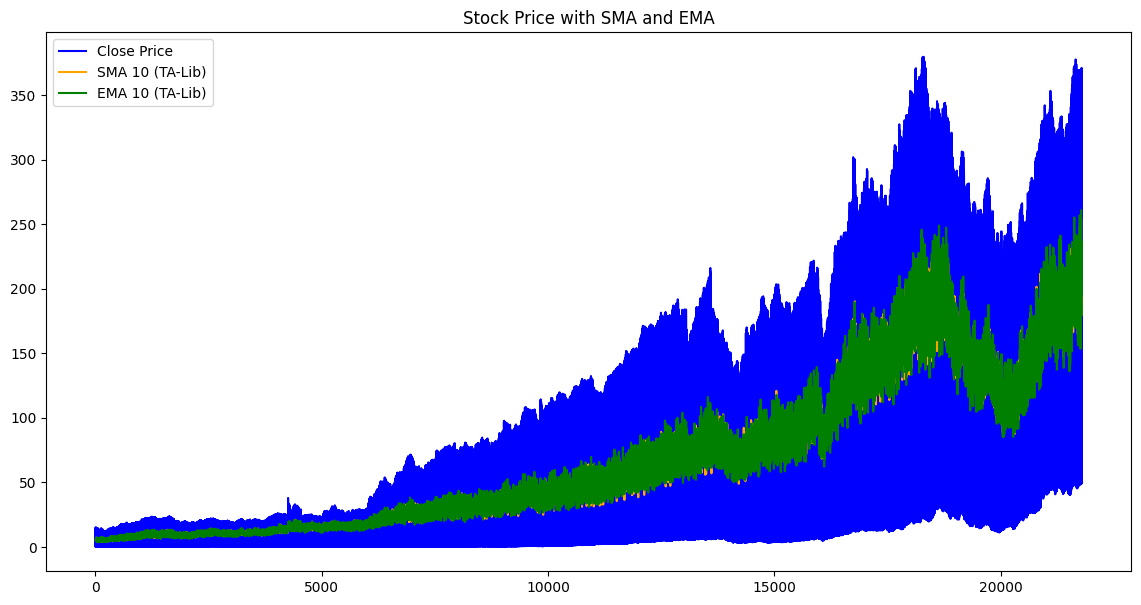

In [ ]:

plt.figure(figsize=(14,7))
plt.plot(df['close'], label='Close Price', color='blue')
plt.plot(df['SMA_10'], label='SMA 10 (TA-Lib)', color='orange')
plt.plot(df['EMA_10'], label='EMA 10 (TA-Lib)', color='green')
plt.title("Stock Price with SMA and EMA")
plt.legend()
plt.show()

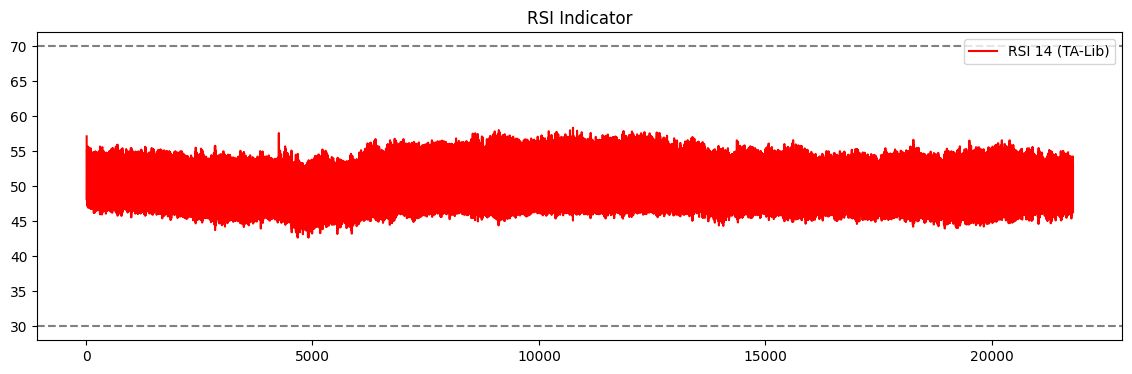

In [29]:
plt.figure(figsize=(14,4))
plt.plot(df['RSI_14'], label='RSI 14 (TA-Lib)', color='red')
plt.axhline(70, color='gray', linestyle='--')
plt.axhline(30, color='gray', linestyle='--')
plt.title("RSI Indicator")
plt.legend()
plt.show()

d:\FAST TRACK CODE\Week_01\10x-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


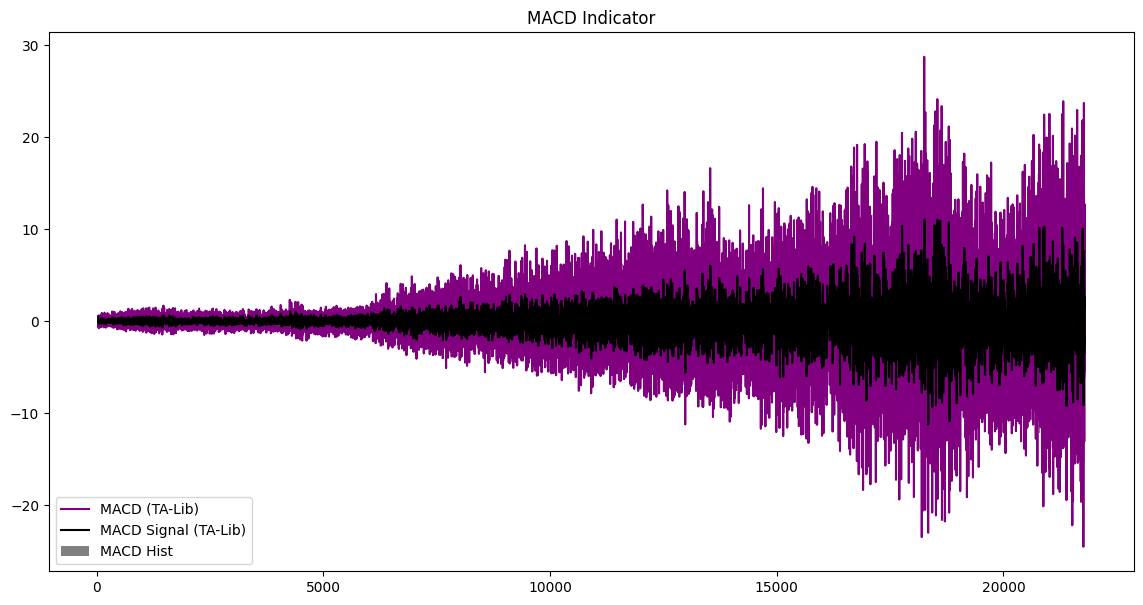

In [30]:
plt.figure(figsize=(14,7))
plt.plot(df['MACD'], label='MACD (TA-Lib)', color='purple')
plt.plot(df['MACD_Signal'], label='MACD Signal (TA-Lib)', color='black')
plt.bar(df.index, df['MACD_Hist'], label='MACD Hist', color='gray')
plt.title("MACD Indicator")
plt.legend()
plt.show()

# ---------------------------
# 7. Save prepared DataFrame
# ---------------------------

In [34]:
df.to_csv("prepared_data/prepared_stock_data.csv")
print("Data saved as 'prepared_stock_data.csv'")

Data saved as 'prepared_stock_data.csv'


#### Sentiment Analysis on News Headlines